In [1]:
using HypothesisTests
using Distributions
using KernelDensity
using Optim
using Interpolations
using StatsBase

using PyPlot 

In [2]:
starting_pwd = pwd()

"/Users/nicholassenno/DataScience/sne_nu/notebooks"

In [3]:
#import some functions and constants to help with cosmology calculations
cd("../code")
include("cosmology.jl")

calc_D_prop (generic function with 1 method)

In [4]:
# Create an immutable type nu which contains the arrival time and direction (Right Assension RA and Declination Dec)
# These objects will be useful when creating random samples 

immutable nu
    mjd::Float64
    ang_err::Float64
    ra::Float64
    dec::Float64
end

# TODO : See if zenith_bin is necessary if we don't consider energy 

# custom type that will store all the relevant information for a SN, including its max time, location, 
# distance (redshift), and the neutrinos associated in its window

type sn
  max_date::Float64
  ra::Float64
  dec::Float64
  z::Float64
  zenith_bin::Int
  nb::Float64
  coefs::Array{Float64,1}

  function sn(max_date::Real,ra::Float64,dec::Float64,z::Float64)
      new_sn = new(max_date,ra,dec,z);
      new_sn.coefs = Float64[];

      return new_sn
  end
end

add_coefs!(t_sn::sn, coefs::Array{Float64,1}) = t_sn.coefs=coefs;
add_nb_and_zenith_bin_idx!(t_sn::sn, nb::Float64, kk::Int) = (t_sn.nb=nb; t_sn.zenith_bin = kk;)

rm_coefs!(t_sn) = t_sn.coefs=Float64[];

## Bkg Dec

Because the background distribution of neutrino arrival declinations does not follow a simple distribution, we will use a sample of neutrinos that are outside of the directional and temporal windows of all SNe. Below, I define functions that find the neutrinos associated with each SN, and then checks which neutrinos are not associated with any SNe. 

I write the values of the backround declinations to the file "bkg_nu_dec_values.dat". To create a background PDF function for later use I read in these values and perform Kernal Density Esitmation with its corresponding interpolation function. 

In [5]:
function find_associated_nus(t_sn::sn, t_nus::Array{nu,1})
    n_hi = 19;
    n_lo = 4;
    alpha = 0.99;
    t_coef = 1.0-2.0*alpha;

    t_len_nu = length(t_nus);

    in_time_window = [t_sn.max_date - n_hi <= t_nus[j].mjd <= t_sn.max_date - n_lo for j in 1:t_len_nu];

    t_kappa = [1./t_nus[j].ang_err.^2 for j in 1:t_len_nu];
    t_mu = [sin(t_sn.dec)*sin(t_nus[j].dec) + cos(t_sn.dec)*
        cos(t_nus[j].dec)*cos(t_sn.ra-t_nus[j].ra) for j in 1:t_len_nu];

    in_ang_window = Array(Bool,t_len_nu);
    acceptance_mu = Array(Float64,t_len_nu);

    for j in 1:t_len_nu
        if t_kappa[j] > 10.0
            acceptance_mu[j] = 1.0 + log(1.0-alpha)/t_kappa[j];
        elseif 1e-2 < t_kappa[j] <= 10.0
            acceptance_mu[j] = log(exp(t_kappa[j]) - 2.0*alpha*sinh(t_kappa[j]))/t_kappa[j];
        elseif 0.0 < t_kappa[j] <= 1e-2
            acceptance_mu[j] = log(1+t_coef*t_kappa[j] + 0.5*t_kappa[j]^2 + t_coef*t_kappa[j]^3/6)/t_kappa[j]
        else
            error("strange kappa in find_associated_nus");
        end
    end
    in_ang_window[:] = t_mu .> acceptance_mu;
    return in_time_window.*in_ang_window;
end

find_associated_nus (generic function with 1 method)

In [6]:
cd("../data/")
nu_data = readdlm("cleaned_nu_data.csv",',',header=true)

(
[55694.0 0.0174533 4.8014 0.682424; 55695.0 0.00872665 1.61443 0.0820305; … ; 56062.0 0.0139626 4.29176 0.645772; 56062.0 0.00349066 6.05455 1.17112],

AbstractString["MJD" "ang_err (rad)" "RA (rad)" "Dec (rad)"])

In [7]:
len_nus = length(nu_data[1][:,1])

69227

In [8]:
#import all of the neutrino data into neutrino structures 
@time nus = [nu(nu_data[1][i,:]...) for i in 1:length(nu_data[1][:,1])];

  0.110161 seconds (610.29 k allocations: 21.959 MB, 5.27% gc time)


In [9]:
sne_data = readdlm("cleaned_sne_data.csv",',',header=true)

(
Any["SN2011ep" 55750.5 … 0.28 "Ic"; "PTF11ixk" 55765.5 … 0.021 "Ic"; … ; "SN2012bw" 56039.5 … 0.0309 "Ic"; "PTF12cde" 56068.5 … 0.0125 "Ib/c"],

AbstractString["Name" "Max Date (MJD)" … "z" "Type"])

In [10]:
sne = [sn(sne_data[1][i,2:5]...) for i in 1:length(sne_data[1][:,1])];

In [11]:
nu_idxs = range(1,len_nus)

1:69227

In [12]:
my_dict = Dict(sne_data[1][i,1] => nu_idxs[find_associated_nus(a_sn,nus)] for (i,a_sn) in enumerate(sne))

Dict{SubString{String},Array{Int64,1}} with 29 entries:
  "SN2011fz" => [35366,35770,35952,36311,36350,36464,36777,36855,36901,37457]
  "SN2011gd" => [14919,15127,15208,15317,15379,15393,15773,15813,16156,16336,16…
  "SN2012bw" => [61808,61826,63038,63335,63840,63979,64031,64403]
  "SN2011ep" => [7168,7376,8445,8538,8726,8907,8996,9082,9811]
  "SN2011gh" => [22813,22942,22948,23005,23308,23531,23557,23791,23945,24031,24…
  "PTF11kaa" => [12166,12168,12251,12406,12533,12833,12962,13754,13765,13974,14…
  "PS1-12sk" => [57023,57323,57385,57408,57429,57637,57754,58361,58393,58586  ……
  "SN2012ap" => [50394,50554,50714,51380,51506,51639,51664,52339,52376]
  "SN2011kf" => [41685,41847,41861,41863,41884,42072,42670,42891,43103,43148,43…
  "PTF11ilr" => [11462,11502,12166,12251,12545,12589,12898,12901,13060,13662,13…
  "SN2011ee" => [11702,12166,12251,12290,12428,12589,12832,12898,12901,13060,13…
  "PTF11kmb" => [21258,21275,21445,21712,21768,22189,22306,22546,22753,22942,23…
  "SN2011kg" => [

In [13]:
function is_contained(val, itr)
    for it in itr
        if val in it
            return true
        end
    end
    
    return false
end

is_contained (generic function with 1 method)

In [27]:
idxs_of_non_associated_nus = [~is_contained(idx,values(my_dict)) for idx in nu_idxs];

In [15]:
writedlm("idx_of_bkg_nus.csv",idxs_of_non_associated_nus,',')

In [16]:
convert(Array{Bool},idxs_of_non_associated_nus);

In [51]:
function get_dec_pdf(t_nu_dec::Array{Float64,1})

    nu_dec_kde = kde(t_nu_dec);
    nu_dec_interp = InterpKDE(nu_dec_kde);

    function (xx) yy = pdf(nu_dec_interp,xx);  return yy > 0 ? yy : NaN end
end

get_dec_pdf (generic function with 1 method)

In [59]:
bkg_dec = [particle.dec for particle in nus[idxs_of_non_associated_nus]];

In [29]:
writedlm("bkg_nu_dec_values.dat",bkg_dec)

In [31]:
nu_dec_kde = kde(bkg_dec);
nu_dec_interp = InterpKDE(nu_dec_kde);

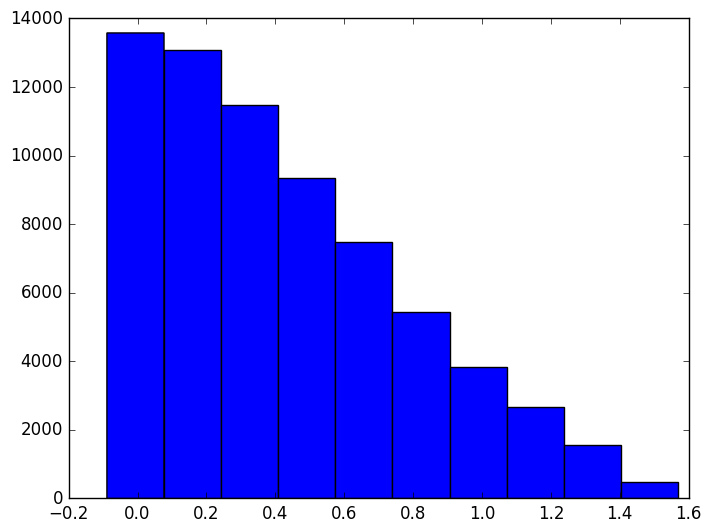

In [62]:
plt[:hist](bkg_dec);

## Sig Dir 

In [ ]:
function S_dir(t_sn::sn,t_nu::nu)
    mu = sin(t_sn.dec)*sin(t_nu.dec) + cos(t_sn.dec)*cos(t_nu.dec)*cos(t_sn.ra-t_nu.ra);
    kappa = 1/t_nu.ang_err^2;

    if kappa > 10.0
        result = kappa/(2*pi)*exp(kappa*(mu-1.0))
    elseif 1e-2 < kappa <= 10.0
        result = kappa/(4*pi*sinh(kappa))*exp(kappa*mu);
    elseif 0.0 < kappa <= 1e-2
        result = (1.0 + kappa*mu)/(4*pi);
    else
        error("strange kappa");
    end
    @assert result >= 0.0;
    return cos(t_nu.dec)*result;
end